In [1]:
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt

# https://corecomputations.wordpress.com/2011/07/26/the-galton-watson-process-part-i/
# https://corecomputations.wordpress.com/2011/08/09/the-galton-watson-process-%e2%80%93-part-ii/

In [2]:
np.random.seed(42)

In [3]:
class Simulator:
    def __init__(self, n_runs, n_gen):
        """
        initialize the simulator
        :param n_runs: number of runs for simulating each Galton-Watson process
        :param n_gen: max number of generation to compute
        """
        self.n_runs = n_runs
        self.n_gen = n_gen

    def run_experiment(self, _lambda):
        """
        Simulate a Galton-Watson process where the number of children of a node is described by a
        Poisson RV with parameter lambda.
        A stop policy is adopted in the cases with lambda > 1:
            P(X=0) = Poisson(0, lambda) -> probability for a node of having 0 children
            P(X=0)^k -> probability that all nodes have 0 children
            P(X=0)^k = (exp(-lambda))^k = exp(-k*lambda)
            --> if this probability is almost 0 stop the simulation
        If lambda > 1 the results array is truncated at the value q where
        q is the analytical probability of survival of the tree computed recursively
        :param _lambda: lambda of the Poisson random variable
        :return: an array with the probability of survival at each generation
        """
        res = np.zeros(self.n_gen)
        for run in range(self.n_runs):
            # l = [np.zeros(1)]
            n_childs = 1
            for i in range(self.n_gen):
                n = stats.poisson.rvs(_lambda, size=n_childs)
                n_childs = np.sum(n)

                stop_condition = math.exp(-_lambda * n_childs)

                if _lambda > 1 and stop_condition == 0:  # when the stop condition is so small that is rounded
                    break                                # to 0 automatically by python

                if n_childs == 0:
                    break

                # l.append(np.zeros(n_childs))

            if res[i] is None:
                res[i] = 0
            else:
                res[i] += 1

        res = 1 - np.cumsum(np.divide(res, self.n_runs))

        if _lambda > 1:
            res = self.truncate_array(res, _lambda)

        return res

    def truncate_array(self, arr, _lambda):
        """
        Compute the probability of survival q for the tree and remove all the values
        of the input array that are less than q
        :param arr: array to truncate
        :param _lambda: lambda of the Poisson random variable
        :return: the array truncated at value q
        """
        q = 1 - self.get_q(_lambda, self.n_runs)
        arr = np.array(arr)
        arr = arr[arr > q]

        return arr.tolist()

    def plot(self, res, lambdas):
        """
        Plot the results
        :param res: list of list containing the results to plot
        :param lambdas: lambda of the Poisson random variable
        :return: None
        """
        plt.figure(figsize=(10,7))

        for i, _lambda in zip(range(len(res)), lambdas):
            r = list(res[i])
            # r.insert(0,1)
            plt.plot(np.linspace(1, len(r), len(r)), r, marker=".", label=f"lambda={_lambda}")

            if _lambda > 1:
                q = 1 - self.get_q(_lambda, self.n_runs)
                plt.axhline(y = q,  color='r', linestyle = ':')

        plt.xscale("log")
        plt.xlabel("Generations")
        plt.ylabel("Probability of survival")
        plt.legend()
        plt.grid()

        plt.show()

    def moment_generating_function(self, _lambda):
        """
        Compute the moment generating function of a Galton-Watson process where the number of
        children of a node is described by a Poisson RV with parameter lambda.
        :param _lambda: lambda of the Poisson random variable
        :return: The theoretical probability of survival
        """
        r = []
        for i in range(1, self.n_gen):
            if i == 1:
                r.append(math.exp(-_lambda))

            r.append(
                math.exp(_lambda * ((r[i-1]) - 1))
            )

        return 1 - np.array(r)

    def get_histogram(self, _lambda):
        """
        Plot the empirical distribution (histogram) on the number of nodes in the tree
        of a Galton-Watson process where the number of children of a node is described by
        a Poisson RV with parameter lambda.
        The number of bins is equal to the Rice criterion -> n_bins = floor(2 * (n**(1/3)))
        :param _lambda: lambda of the Poisson random variable
        :return: None
        """
        res = []
        for run in range(self.n_runs):
            n_nodes = 1
            n_childs = 1
            for i in range(self.n_gen):
                n = stats.poisson.rvs(_lambda, size=n_childs)
                n_childs = np.sum(n)
                n_nodes += 1

                stop_condition = math.exp(-_lambda * n_childs)
                if _lambda > 1 and stop_condition == 0:
                    break

                if n_childs == 0:
                    break

            res.append(n_nodes)

        weights = np.ones_like(res) / len(res)

        plt.figure(figsize=(10,7))
        plt.hist(res, bins=int(math.floor(len(res)**(1./3))), weights=weights, label=f"lambda={_lambda}")
        plt.legend()
        plt.grid()
        plt.xlabel("Generations")
        plt.ylabel("Empirical probability of extinction")
        plt.show()

    def get_q(self, _lambda, n):
        """
        Compute the probability of extinction of a Galton-Watson process where the number
        of children of a node is described by a Poisson RV with parameter lambda.
            P(X=i) => Poisson(i, lambda) = lambda^i / factorial(i) * exp(-lambda)
            phi_X(z) = sum(P(X=k)*z^k) = exp(lambda*(z-1))
            q_i = phi_Y(q_{i-1}) = q_1 + ... + q_i = phi_1(0) + ... + phi_i(0) =
                = exp(-lambda) + epx(lambda*(exp(-lambda)-1)) + ...
        :param _lambda: lambda of the Poisson random variable
        :param n: number of generations of the Galton-Watson process
        :return: probability of extinction q
        """
        q = 0
        for i in range(1, n):
            q = math.exp(_lambda * (q - 1))

        return q

    def compute_moment_generating_function(self, lambdas):
        """
        Compute analytically the probability of survival of a Galton-Watson process where the number
        of children of a node is described by a Poisson RV with parameter lambda
        :param lambdas: list of lambdas
        :return: list of list with the probability of survival for each generation
                 of a Galton-Watson process for each lambda
        """
        res = []
        for _lambda in lambdas:
            res.append(self.moment_generating_function(_lambda))

        return res

    def simulate(self, lambdas):
        """
        Simulate the probability of survival of a Galton-Watson process where the number
        of children of a node is described by a Poisson RV with parameter lambda
        :param lambdas: list of lambdas
        :return: list of list with the probability of survival for each generation
                 of a Galton-Watson process for each lambda
        """
        res = []
        for _lambda in lambdas:
            res.append(self.run_experiment(_lambda))

        return res


In [4]:
lambdas = [0.6, 0.8, 0.9, 0.95, 0.99, 1.01, 1.05, 1.1, 1.3]

s = Simulator(10000, 500)

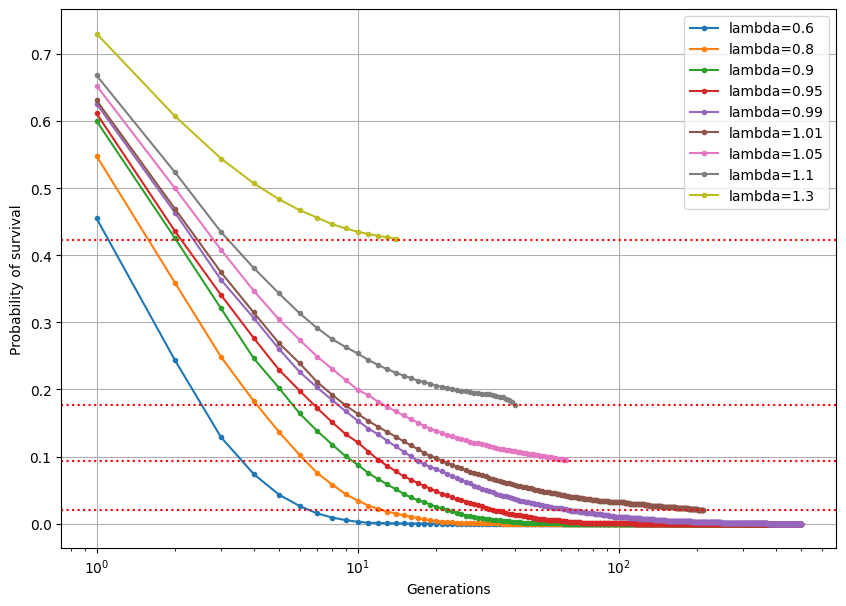

In [5]:
res = s.simulate(lambdas)
s.plot(res, lambdas)

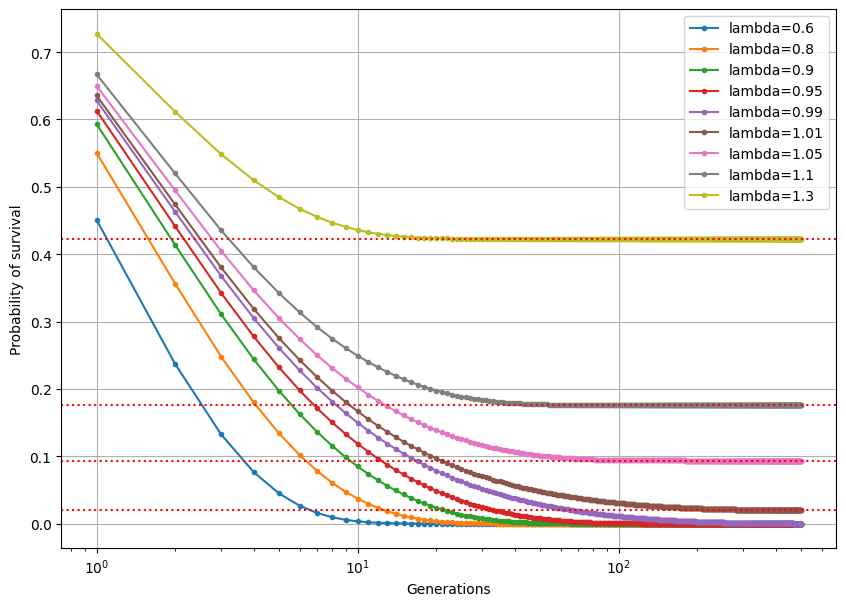

In [6]:
res = s.compute_moment_generating_function(lambdas)
s.plot(res, lambdas)

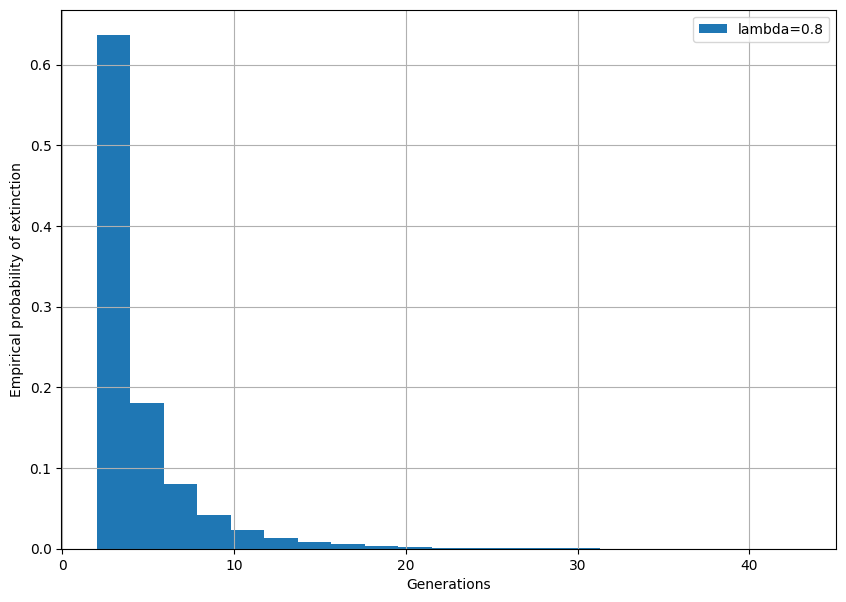

In [7]:
s.get_histogram(0.8)

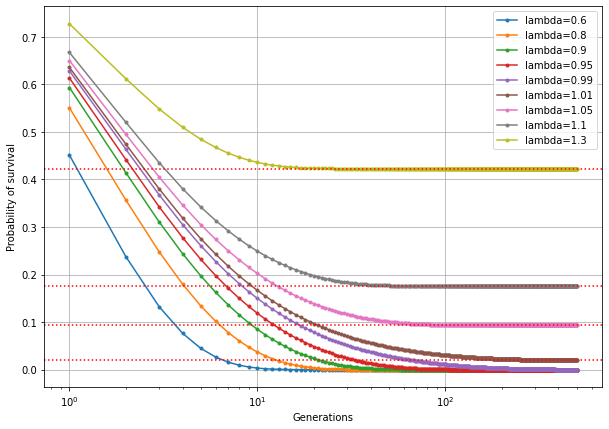

In [38]:
res = s.compute_moment_generating_function(lambdas)
s.plot(res, lambdas)

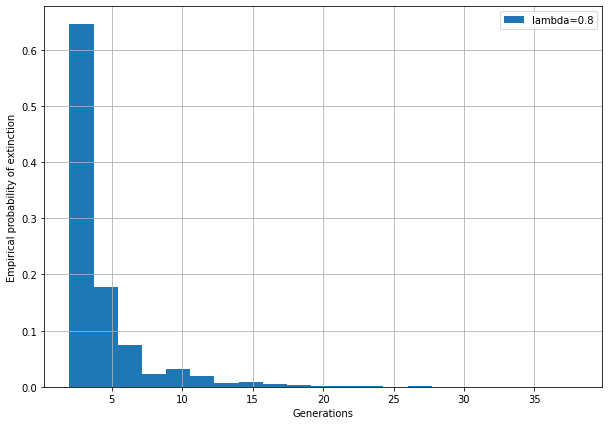

In [17]:
s.get_histogram(0.8)

In [2]:
m = [[1,1,1,1],
     [1,1,1,1],
     [1,1,1,1]]

In [4]:
a = np.array(m)

In [13]:
a[..., :13]

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])